In [154]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [155]:
seq_length = 5
data_dim = 5
hidden_dim = 5
output_dim = 1
learning_rate = 0.01
iterations = 1300
layer_size = 3

In [156]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [157]:
x1 = np.loadtxt('x0913.csv', delimiter=',')
y1 = np.loadtxt('y14_1.csv', delimiter=',')
x2 = np.loadtxt('x1014.csv', delimiter=',')
y2 = np.loadtxt('y15_1.csv', delimiter=',')
x3 = np.loadtxt('x1115.csv', delimiter=',')
y3 = np.loadtxt('y16_1.csv', delimiter=',')
x = np.vstack([x1,x2])
y = np.vstack([y1,y2])
x = x.reshape([-1,data_dim])
y = y.reshape([-1,output_dim])

In [200]:
x_norm = MinMaxScaler(x).reshape([-1,seq_length, data_dim])
y_norm = MinMaxScaler(y).reshape([-1,output_dim])
print("X Shape: ", x_norm.shape)
print("Y Shape: ", y_norm.shape)

X Shape:  (846, 5, 5)
Y Shape:  (846, 1)


In [201]:
size = 323
x_train = x_norm[:size,:,:]
y_train = y_norm[:size,:]
x_test = x_norm[size:,:,:]
y_test = y_norm[size:,:]
print("train X Y Shape", x_train.shape, y_train.shape)
print("test X Y Shape", x_test.shape, y_test.shape)

train X Y Shape (323, 5, 5) (323, 1)
test X Y Shape (523, 5, 5) (523, 1)


In [202]:
tmp = MinMaxScaler(x)
tmp[:,1]

array([0.02250192, 0.01971394, 0.0196591 , ..., 0.0153576 , 0.01584943,
       0.0123388 ])

In [203]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [204]:
with tf.name_scope("RNN_init_state"):
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.softsign)
multi_cells = tf.contrib.rnn.MultiRNNCell([cell]*layer_size, state_is_tuple=True)
with tf.name_scope("RNN"):
    outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)

In [205]:
with tf.variable_scope('loss'):
    loss = tf.reduce_sum(tf.square(Y_pred - Y))
tf.summary.histogram("loss", loss)    


optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

tf.summary.histogram("Y_pred", Y_pred)

<tf.Tensor 'Y_pred:0' shape=() dtype=string>

In [210]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])

rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


[step: 0] loss: 34.17633056640625
[step: 100] loss: 1.2529182434082031
[step: 200] loss: 1.1438570022583008
[step: 300] loss: 1.1041600704193115
[step: 400] loss: 1.0751205682754517
[step: 500] loss: 1.03348708152771
[step: 600] loss: 0.8988573551177979
[step: 700] loss: 0.8257468342781067
[step: 800] loss: 0.7964227795600891
[step: 900] loss: 0.7800962924957275
[step: 1000] loss: 0.7629782557487488
[step: 1100] loss: 0.7393842935562134
[step: 1200] loss: 0.7243183255195618
RMSE: 0.0654212161898613


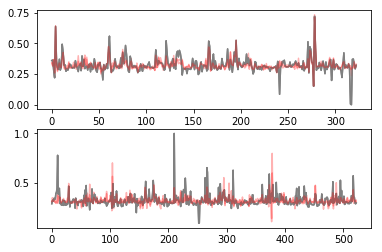

In [212]:
with tf.Session() as sess:
#     tf.reset_default_graph()
    init = tf.global_variables_initializer()
    sess.run(init)
#     train_writer = tf.summary.FileWriter('./logs/1/train', sess.graph)
    # Training step
    for i in range(iterations):
        merged = tf.summary.merge_all()
        _, step_loss, pred = sess.run([train, loss, Y_pred], feed_dict={
                                X: x_train, Y: y_train})
#         train_writer.add_summary(summary, i)
        if(i%100==0):
            print("[step: {}] loss: {}".format(i, step_loss))
        
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: x_test})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: y_test, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    
    plt.subplot(2,1,1)
    plt.plot(y_train, 'grey')
    plt.plot(pred, 'r', alpha=0.3)
    plt.subplot(2,1,2)
    plt.plot(y_test, 'grey')
    plt.plot(test_predict, 'r', alpha=0.3)
    plt.show()

In [170]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 5, 5) dtype=float32>

In [171]:
tmp_train = pd.DataFrame({'train_pred': pred.tolist(), 'train_real': y_train.tolist()})
tmp_train

,train_pred,train_real
0,[0.15909108519554138],[0.16709175227003004]
1,[0.16101562976837158],[0.16716981421424487]
2,[0.1717280149459839],[0.16694684825152692]
3,[0.16094070672988892],[0.15200164766320495]
4,[0.16718757152557373],[0.1670636428798273]
5,[0.16198182106018066],[0.17235448682077437]
6,[0.16464407742023468],[0.17454489821584765]
7,[0.1626160889863968],[0.16971654716375706]
8,[0.16706787049770355],[0.18730446872918136]
9,[0.1603376567363739],[0.15975306882999446]


In [16]:
tmp_test = pd.DataFrame({'test_pred': test_predict.tolist(), 'test_real': y_test.tolist()})
tmp_test

,test_pred[09-15][16],test_real
0,[0.33481088280677795],[0.35679191425047035]
1,[0.3773342967033386],[0.4020300291402025]
2,[0.383046418428421],[0.4075483243778911]
3,[0.40388450026512146],[0.38755833668088085]
4,[0.3855047821998596],[0.367378224047388]
5,[0.37342432141304016],[0.3513714626314585]
6,[0.3357808291912079],[0.33548986443736967]
7,[0.3676690459251404],[0.363471615903136]
8,[0.3754534125328064],[0.40658016292721577]
9,[0.3694070279598236],[0.4233238673664181]


In [17]:
tmp_train.to_csv("compare_train_without_company[09-15][16].csv", header=True, index=False)
tmp_test.to_csv("compare_test_without_company[09-15][16].csv", header=True, index=False)